# Imports

In [1]:
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as mpl
import matplotlib.colors
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from plotnine import *
import scipy.stats as ss
import scipy.io as si
import sys, os, argparse
import harmonypy as hm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
import galaxy_20230607_2

In [5]:
def get_cluster_proportions(adata,
                            cluster_key="leiden",
                            sample_key="condition",
                            drop_values=None):
    """
    Input
    =====
    adata : AnnData object
    cluster_key : key of `adata.obs` storing cluster info
    sample_key : key of `adata.obs` storing sample/replicate info
    drop_values : list/iterable of possible values of `sample_key` that you don't want
    Returns
    =======
    pd.DataFrame with samples as the index and clusters as the columns and 0-100 floats
    as values
    """
    adata_tmp = adata.copy()
    sizes = adata_tmp.obs.groupby([cluster_key, sample_key]).size()
    props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).unstack(level=1)
    #props = props.pivot(columns=sample_key, index=cluster_key).T
    props.index = props.index.droplevel(0)
    props.fillna(0, inplace=True)
    if drop_values is not None:
        for drop_value in drop_values:
            props.drop(drop_value, axis=0, inplace=True)
    return props

In [6]:
import gseapy as gp

In [7]:
def read_geneset(gmt_file):
    genesets = {}
    with open(gmt_file, 'r') as f:
        unsplit = f.read().split('\n')
        for sig in unsplit:
            gene_arr = sig.split('\t')
            if gene_arr[0] != '':
                # first entry is name, skip description, rest are genes
                genesets[gene_arr[0]] = gene_arr[2:]
    return genesets

In [ ]:
hallmarks= read_geneset("/path/to/genesigs/hallmark.all.mouse.gmt")
hms = "/path/to/genesigs/hallmark.all.mouse.gmt"

In [10]:
def gg_plot_de(df, comparison, genes, x_label, title):
    df = df[df.comparison == comparison]
    plot = (ggplot(aes(x=x_label, y='mean'), df)
     + geom_jitter(alpha=0.1)
     + theme(axis_text_x=element_text(rotation=90, hjust=1))
     + geom_point(aes(x=x_label, y='mean', color='gene', size='fdr'), df[df.gene.isin(genes)])
     + scale_size(range = [5, 1],
           breaks =  [0, 0.01, 0.05, .5, 1],
           labels = ["0", "0.01", "0.05", ".5", "1"])
     + ylab(str('log fold change '))
     + xlab('')
     + ggtitle(title)
    )
    return plot

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

In [12]:
from itertools import combinations

In [13]:
def stratified_downsample(adata, colname, smaller_lb, larger_lb, cluster_colname):
    """ Stratified downsampling of adata by cell type
    inputs: colname, condition or attribute to be used as downsampled grouping
            smaller_lb, the smaller of two groups within colname
            larger_lb, the larger of two groups within colname
            cluster_colname, .obs colname to use for stratification
    output: downsampled adata
    """
    #recalculating the size
    smaller_size = (adata.obs[colname] == smaller_lb).sum()
    larger_size = (adata.obs[colname] == larger_lb).sum()
    print('Downsampling larger set ({} [{}]) to smaller set ({} [{}])'.format(larger_lb, larger_size, smaller_lb, smaller_size))
    sss = StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=1-smaller_size/larger_size)
    #series with cell counts in each leiden cluster
    class_counts = adata[adata.obs[colname] == larger_lb].obs[cluster_colname].value_counts()
    #if there are less than 2 cells remove cluster
    small_classes = class_counts[class_counts < 2].index
    if len(small_classes) > 0:
        print('Removing classes because less than 2 cells')
        for x in small_classes:
            print(x)
        adata = adata[~adata.obs[cluster_colname].isin(small_classes)]
    for keep_idx, rm_idx in sss.split(adata[adata.obs[colname] == larger_lb].obs.index, adata[adata.obs[colname] == larger_lb].obs[cluster_colname]):
        #passing to sss.split the cell barcodes corresponding with condition and their leiden cluster calls
        #This function will take the smaller / larger proportion from each cluster
        rm_idx = adata[adata.obs[colname] == larger_lb].obs.iloc[rm_idx, :].index
        return adata[[x not in rm_idx for x in adata.obs.index]]

In [ ]:
cd /path/to/outdir

In [15]:
OUTDIR = 'path/to/outdir'
sc.settings.figdir = OUTDIR

# Palettes

In [25]:
greyred = matplotlib.colors.LinearSegmentedColormap.from_list("", ["gainsboro","#FF2600"])

In [26]:
KEO_palette = {
 'Progenitor CD8+': 'salmon',
 'Early Effector CD8+': 'red',
 'CD4+': 'darkred',
 'NK Cells': 'mistyrose',
 'B Cells': 'coral',
 'IRE-hi Macs': 'dodgerblue',
 'pDCs': 'moccasin',
 'CD11b+ cDCs': 'orangered',
 'migDCs': 'gold',
 'ISG-hi Mo': 'plum',
 'Inflammatory Mo': 'mediumvioletred',
 'Neutrophils': 'tan',
 #'M1 Mac': 'cornflowerblue',
 'MDSC': 'lightsteelblue',
 'M2b Mac': 'navy',
 'Fibroblasts': 'forestgreen',
 'Erythrocytes': 'lightseagreen',
 'Mast cells': 'chocolate', 
 'Mt-gene-hi myeloid': 'deepskyblue', 
 #'TAMΦ 1': 'blue', 
 'M2a Mac': 'darkslateblue',
 'Mac/Mo Hybrid': 'mediumorchid', 
 'Mki67+ Lymphocytes': 'lightpink', 
 'Cx3cr1+ Mo': 'darkmagenta',
 'Terminal Effector CD8+':'indianred',
 'CD103+ cDC 1':'orange',
 'CD103+ cDC 2': 'darkorange',
 'Ribo-hi Lymphocytes':'palevioletred'
}

In [27]:
tnk_palette = {
 'NK Cells': 'orange',
 'Mki67+ CD8+': 'red',
 'Progenitor CD8+': 'lightgrey',
 'Terminal Effector CD8+': 'indianred',
 'Early Effector CD8+': 'peachpuff',
 'Foxp3+ CD4+': 'indigo',
 'Gzm-hi CD8+': 'maroon',
 'Malat1-hi CD8+': 'dimgray'
}

In [28]:
CD38_palette = {
 'CD38_neg': 'gainsboro',
 'CD38_pos': '#FF2600'
}

# Loading in processed .h5ad from TBK1 project

In [12]:
adata = sc.read_h5ad('path/to/tkb1.h5ad')

# Subset to only isotype and PD1 tx samples

In [15]:
adata.obs.treatment

AAACCCACACCGTGAC-1-0     Combo
AAACGAACAAAGACTA-1-0     Combo
AAACGCTCAGGCGTTC-1-0     Combo
AAAGGGCTCCTCTCTT-1-0     Combo
AAAGGGCTCGCTAGCG-1-0     Combo
                         ...  
TTTGGTTTCCCGTTGT-1-14    TBK1i
TTTGTTGAGGAACGCT-1-14    TBK1i
TTTGTTGCAAGGTCTT-1-14    TBK1i
TTTGTTGGTAACCCTA-1-14    TBK1i
TTTGTTGGTAAGGCCA-1-14    TBK1i
Name: treatment, Length: 53637, dtype: category
Categories (4, object): ['Combo', 'Isotype', 'TBK1i', 'aPD1']

In [16]:
pd1 = adata[adata.obs['treatment'].isin(['Isotype','aPD1'])]

# Reset highly variable genes, re-embed, and re-harmonize

In [ ]:
sc.pp.filter_genes(pd1, min_cells=3)
sc.pp.highly_variable_genes(pd1, n_top_genes=10000)
print('highly variable genes selected: {}'.format(pd1.var.highly_variable.sum()))
pca = TruncatedSVD(n_components=50, algorithm='arpack')
Xpca = pca.fit_transform(pd1[:, pd1.var.highly_variable].X)
pd1.obsm['X_pca'] = Xpca
sc.pp.neighbors(pd1, use_rep='X_pca')
sc.tl.umap(pd1)
sc.tl.leiden(pd1, key_added='pd1_leiden')

In [21]:
data = pd1.obsm['X_pca']
meta_data = pd1.obs
ho = hm.run_harmony(data, meta_data, ['GEM_BATCH','batch'], max_iter_harmony=20)
pd1.obsm['X_harmony'] = ho.Z_corr.transpose()

2023-06-15 14:03:04,088 - harmonypy - INFO - Iteration 1 of 20
2023-06-15 14:03:11,673 - harmonypy - INFO - Iteration 2 of 20
2023-06-15 14:03:15,760 - harmonypy - INFO - Iteration 3 of 20
2023-06-15 14:03:20,500 - harmonypy - INFO - Iteration 4 of 20
2023-06-15 14:03:22,790 - harmonypy - INFO - Converged after 4 iterations


In [22]:
sc.pp.neighbors(pd1, use_rep='X_harmony')
sc.tl.umap(pd1)

# Choosing a leiden solution

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


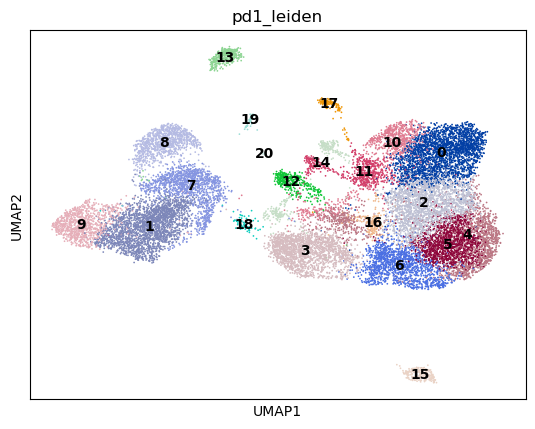

In [27]:
sc.pl.umap(pd1, color='pd1_leiden', legend_loc='on data')

In [58]:
sc.tl.leiden(pd1, resolution=1.4, key_added='pd1_leiden_1.4')

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


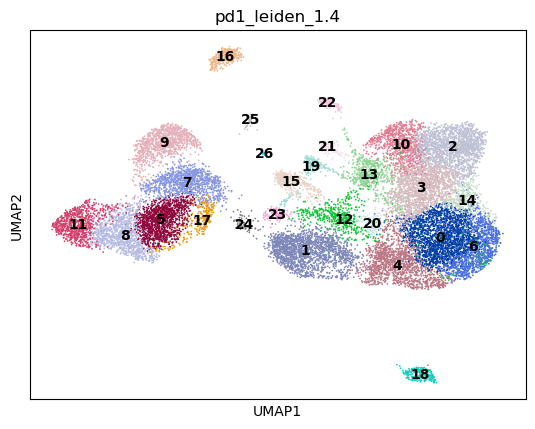

In [59]:
sc.pl.umap(pd1, color='pd1_leiden_1.4', legend_loc='on data')

# Re-calling clusters using new leiden solution

In [60]:
sc.tl.rank_genes_groups(pd1, groupby='pd1_leiden_1.4', method='t-test_overestim_var', key_added='pd1_rgg_1.4')

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

In [157]:
new_calls = {
        0: 'MDSC',
        1: 'IRE-hi Macs',
        2: 'ISG-hi Mo',
        3: 'Inflammatory Mo',
        4: 'M2b Mac',
        5: 'Early Effector CD8+',
        6: 'MDSC',
        7: 'Progenitor CD8+',
        8: 'Terminal Effector CD8+',
        9: 'NK Cells',
        10: 'Cx3cr1+ Mo',
        11: 'Mki67+ Lymphocytes',
        12: 'Mt-gene-hi myeloid',
        13: 'CD11b+ cDCs',
        14: 'Mac/Mo Hybrid',
        15: 'Neutrophils',
        16: 'B Cells',
        17: 'CD4+',
        18: 'Erythrocytes',
        19: 'migDCs',
        20: 'M2a Mac',
        21: 'CD103+ cDC 1',
        22: 'pDCs',
        23: 'CD103+ cDC 2',
        24: 'Ribo-hi Lymphocytes',
        25: 'Fibroblasts',
        26: 'Mast cells'
}
conditions = pd1.obs['pd1_leiden_1.4'].astype(int).map(new_calls)
pd1.obs["pd1_clusters_1.4"] = np.where(pd1.obs['pd1_leiden_1.4'].astype(int).isin(new_calls.keys()), conditions.astype('category'), pd1.obs['pd1_leiden_1.4'])

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


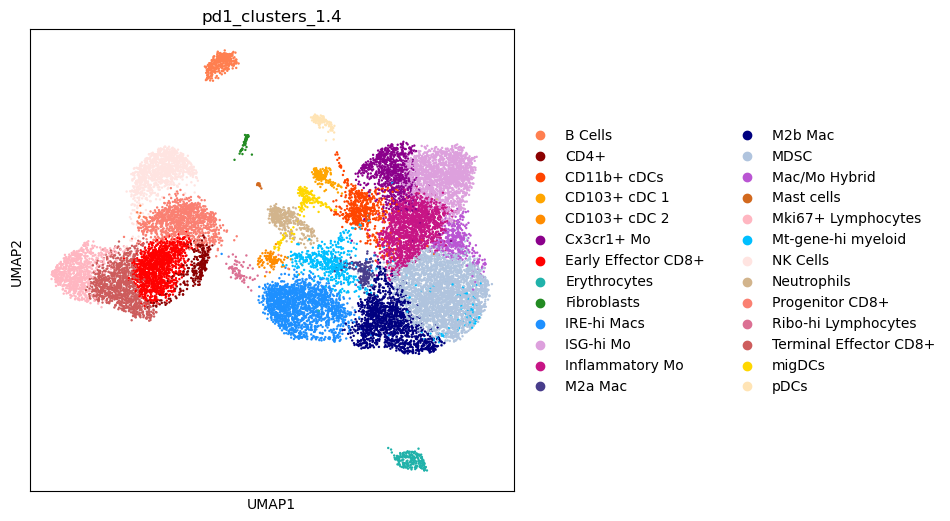

In [20]:
with mpl.rc_context(({'figure.figsize': (6.25,6)})):
    sc.pl.umap(pd1, color='pd1_clusters_1.4', palette=KEO_palette, size=12, save='bulklabels.pdf')

# Downsample and galaxy

In [15]:
pd1_ds = pd1.copy()

In [17]:
keys= pd1_ds.obs["treatment"].unique()
size_order = pd1_ds.obs["treatment"].value_counts().sort_values().index
comb_df = pd.DataFrame(list(combinations(keys, 2)))
comb_df[0] = pd.Categorical(comb_df[0], categories=size_order, ordered=True)
comb_df[1] = pd.Categorical(comb_df[1], categories=size_order, ordered=True)
comb_df = comb_df.sort_values(0).sort_values(1)
# check that sample sizes are within 10% of each other
for c in comb_df.values:
    s1 = (pd1_ds.obs["treatment"] == c[0]).sum()
    s2 = (pd1_ds.obs["treatment"] == c[1]).sum()
    if abs(s1 - s2) / max(s1, s2) > 0.1:
        larger = c[np.argmax([s1, s2])]
        smaller = c[np.argmin([s1, s2])]
        pd1_ds = stratified_downsample(pd1_ds, "treatment", smaller, larger, 'pd1_clusters_1.4')

Downsampling larger set (aPD1 [12576]) to smaller set (Isotype [6638])


0         3.883393
1         3.625540
2         3.306704
3        11.682246
4        -2.988908
           ...    
13270     9.656986
13271    10.383994
13272    -4.421132
13273     5.276963
13274    -5.331359
Name: x, Length: 13275, dtype: float32
0         5.406084
1         8.079747
2         5.622385
3         7.033167
4        12.779123
           ...    
13270     4.147996
13271    10.529007
13272     8.323318
13273    12.305010
13274     7.613626
Name: y, Length: 13275, dtype: float32


/Users/sanderso/Library/CloudStorage/GoogleDrive-sanderso@broadinstitute.org/Shared drives/Manguso_Lab_Compbio/11_computational_biology/methods/scRNAseq/10x_pipeline/galaxy_20230607_2.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

/Users/sanderso/Library/CloudStorage/GoogleDrive-sanderso@broadinstitute.org/Shared drives/Manguso_Lab_Compbio/11_computational_biology/methods/scRNAseq/10x_pipeline/galaxy_20230607_2.py:66: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

/Users/sanderso/Library/CloudStorage/GoogleDrive-sanderso@broadinstitute.org/Shared drives/Manguso_Lab_Compbio/11_computational_biology/methods/scRNAseq/10x_pipeline/galaxy_20230607_2.py:66: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in se

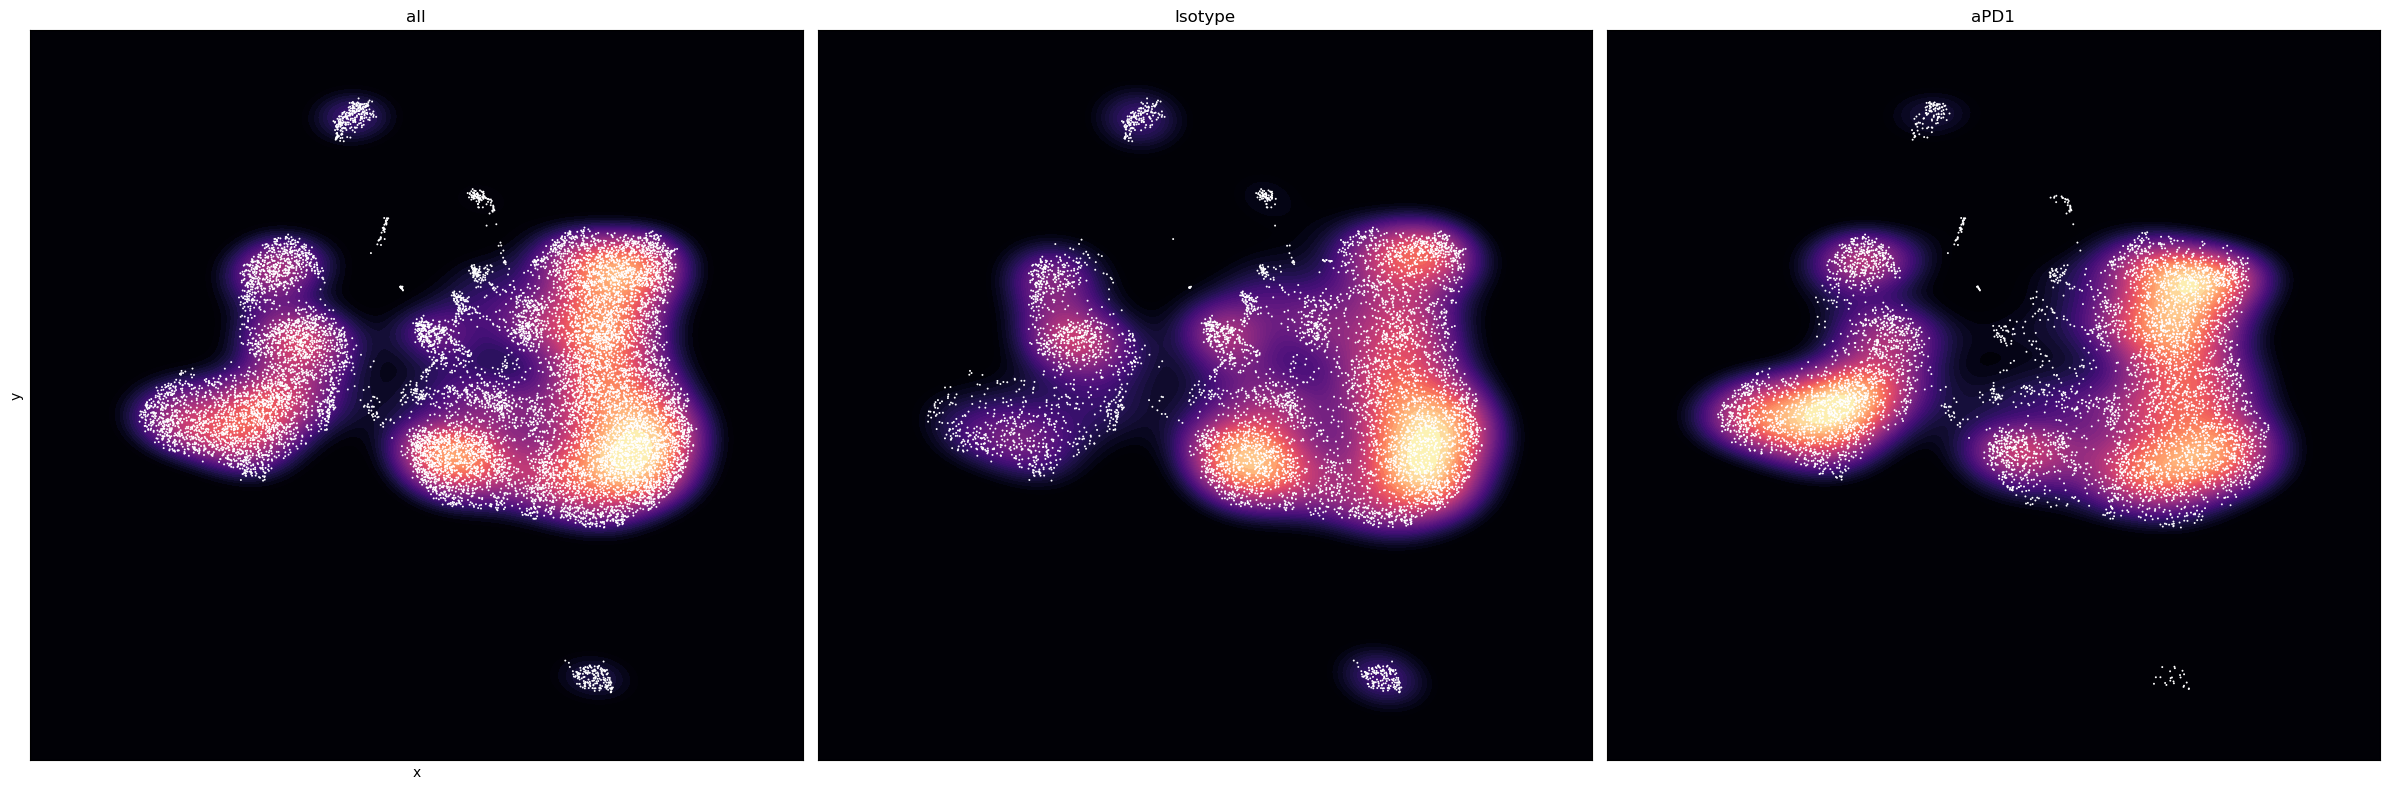

In [25]:
galaxy_20230607_2.galaxy_plot(pd1_ds, OUTDIR, 'treatment')

In [52]:
pd1_ds.write_h5ad(os.path.join(OUTDIR, 'pd1_ds.h5ad'))

# Cluster proportions

In [27]:
bulk_prop = get_cluster_proportions(pd1, cluster_key='pd1_clusters_1.4', sample_key='replicate')

In [28]:
bulk_prop

pd1_clusters_1.4   B Cells      CD4+  CD11b+ cDCs  CD103+ cDC 1  CD103+ cDC 2  \
replicate                                                                       
iso_1             1.346801  1.346801     1.582492      0.572391      0.606061   
iso_2             4.228422  2.484743     6.190061      1.220575      0.741064   
iso_3             1.892285  0.800582     3.566230      0.436681      0.655022   
pd1_1             1.298701  0.874636     2.173337      0.715611      0.291545   
pd1_2             0.676879  1.638760     3.384396      0.712504      0.819380   
pd1_3             2.969963  1.214985     3.307459      0.506244      0.506244   
pd1_4             1.252885  1.549621     2.571711      0.956149      0.560501   

pd1_clusters_1.4  Cx3cr1+ Mo  Early Effector CD8+  Erythrocytes  Fibroblasts  \
replicate                                                                      
iso_1               1.481481             2.525253      1.784512     0.033670   
iso_2               3.051439             1.482127      0.174368     0.000000   
iso_3               4.148472             1.237263      7.278020     0.000000   
pd1_1               5.274318             7.845216      0.795123     0.079512   
pd1_2               3.313146             9.547560      0.000000     1.211258   
pd1_3               5.669929             8.336146      0.371245     0.202497   
pd1_4               6.791955            11.902407      0.164853     0.362677   

pd1_clusters_1.4  IRE-hi Macs  ...  Mast cells  Mki67+ Lymphocytes  \
replicate                      ...                                   
iso_1                9.259259  ...    0.033670            2.255892   
iso_2               10.113339  ...    0.217960            1.482127   
iso_3               25.909753  ...    0.000000            1.528384   
pd1_1                7.765704  ...    0.053008            6.281474   
pd1_2                9.832561  ...    0.142501            4.061275   
pd1_3                6.581168  ...    0.033750            3.712454   
pd1_4                4.747774  ...    0.230795            6.923838   

pd1_clusters_1.4  Mt-gene-hi myeloid  NK Cells  Neutrophils  Progenitor CD8+  \
replicate                                                                      
iso_1                       7.205387  2.154882     4.579125         6.262626   
iso_2                       3.007847  8.413252     1.874455         5.841325   
iso_3                       1.455604  2.328967     5.385735         5.167394   
pd1_1                       2.332362  6.228465     0.344553         4.505698   
pd1_2                       1.995012  4.773780     0.890631         4.738155   
pd1_3                       3.476207  5.602430     1.586230         5.973675   
pd1_4                       1.549621  5.967689     0.890208         6.264425   

pd1_clusters_1.4  Ribo-hi Lymphocytes  Terminal Effector CD8+    migDCs  \
replicate                                                                 
iso_1                        0.101010                3.973064  1.784512   
iso_2                        0.261552                3.443766  2.136007   
iso_3                        0.218341                2.765648  1.237263   
pd1_1                        0.238537                5.724887  0.318049   
pd1_2                        0.320627                5.949412  0.819380   
pd1_3                        0.877489                7.154911  0.539993   
pd1_4                        0.329707                6.824926  0.197824   

pd1_clusters_1.4      pDCs  
replicate                   
iso_1             0.404040  
iso_2             1.569311  
iso_3             1.164483  
pd1_1             0.503578  
pd1_2             0.463128  
pd1_3             0.337496  
pd1_4             0.263765  

[7 rows x 26 columns]

In [29]:
bulk_prop.to_csv(os.path.join(OUTDIR, 'bulk_clustprop.csv'))

# Exploring CD38 expression

In [202]:
sc.tl.score_genes(pd1, gene_list=['Cd38'], score_name='CD38_score')

In [11]:
greyred = matplotlib.colors.LinearSegmentedColormap.from_list("", ["gainsboro","#FF2600"])

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


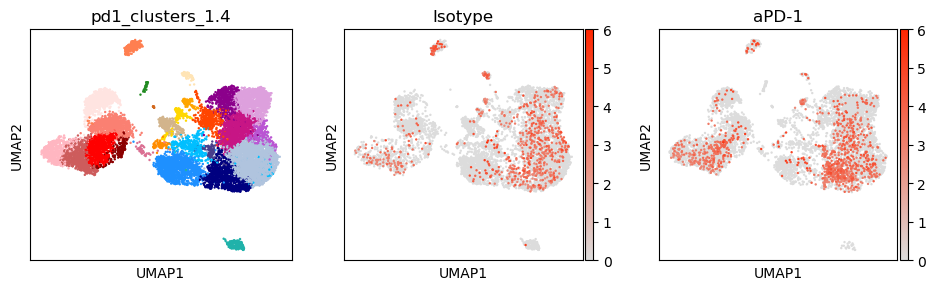

In [28]:
fig, (ax1, ax2, ax3) = mpl.subplots(1, 3, figsize=(11.5,3), gridspec_kw={'wspace':0.2}) 
sc.pl.umap(pd1_ds, color='pd1_clusters_1.4', palette=KEO_palette, size=12, ax=ax1, legend_loc=None, show=False)
sc.pl.umap(pd1_ds[pd1_ds.obs.treatment=='Isotype'], color='Cd38', cmap=greyred, size=12, ax=ax2, show=False, vmax=6, title='Isotype')
sc.pl.umap(pd1_ds[pd1_ds.obs.treatment=='aPD1'], color='Cd38', cmap=greyred, size=12, ax=ax3, show=False, vmax=6, title='aPD-1')

mpl.savefig('bulk_downsample_cd38.pdf')

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


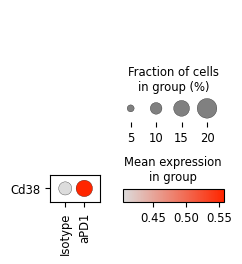

In [72]:
sc.pl.dotplot(pd1, groupby='treatment', var_names='Cd38', cmap=greyred, swap_axes=True)

In [240]:
pd1.obs.loc[pd1.obs.CD38_score <= 0, 'CD38_status'] = 'CD38_neg'

In [241]:
pd1.obs.loc[pd1.obs.CD38_score > 0, 'CD38_status'] = 'CD38_pos'

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


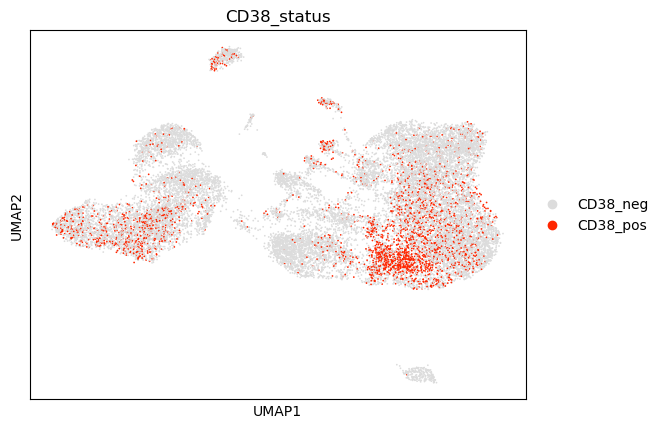

In [259]:
sc.pl.umap(pd1, color='CD38_status', palette=CD38_palette)

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided 

<Axes: title={'center': 'aPD-1'}, xlabel='UMAP1', ylabel='UMAP2'>

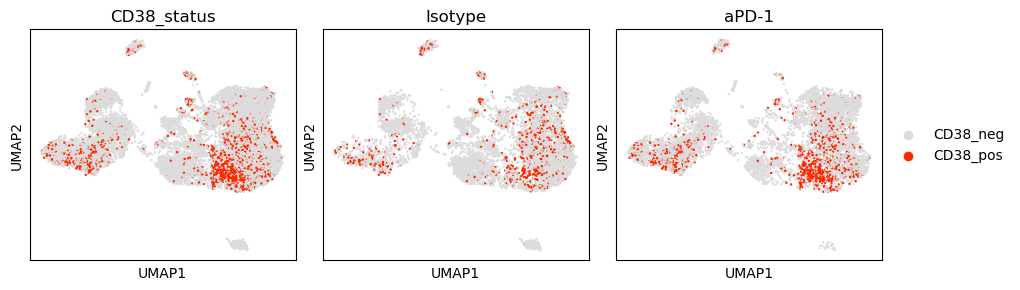

In [25]:
fig, (ax1, ax2, ax3) = mpl.subplots(1, 3, figsize=(11,3), gridspec_kw={'wspace':0.1}) 
sc.pl.umap(pd1_ds, color='CD38_status', palette=CD38_palette, size=12, ax=ax1, legend_loc=None,show=False)
sc.pl.umap(pd1_ds[pd1_ds.obs.treatment=='Isotype'], color='CD38_status', palette=CD38_palette, legend_loc=None,size=12, ax=ax2, show=False, title='Isotype')
sc.pl.umap(pd1_ds[pd1_ds.obs.treatment=='aPD1'], color='CD38_status', palette=CD38_palette, size=12, ax=ax3, show=False, title='aPD-1')

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


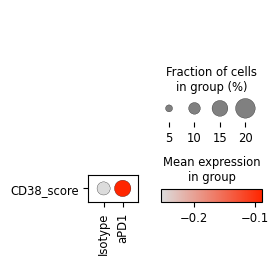

In [18]:
sc.pl.dotplot(pd1, groupby='treatment', var_names='CD38_score', swap_axes=True, cmap=greyred)

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


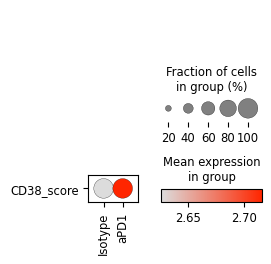

In [17]:
sc.pl.dotplot(pd1[pd1.obs['CD38_status']=='CD38_pos'], groupby='treatment', var_names='CD38_score', swap_axes=True, cmap=greyred)

# GSEA - All CD38+ vs all CD38-

In [84]:
pd1.write_h5ad(os.path.join(OUTDIR, 'pd1.h5ad'))

In [31]:
de_pd1 = pd.read_table('/path/to/CD38_pos_CD38_neg_lrLRT.txt', index_col=0)
de_pd1 = de_pd1[['signed_logfdr']].reset_index()

In [32]:
pre_res_pd1 = gp.prerank(rnk=de_pd1, gene_sets=hms,
                     processes=4,
                     permutation_num=5000, # reduce number to speed up testing
                     outdir='/path/to/CD38/GSEA_outdir', format='png', seed=6)

/var/folders/jz/6g1djx7n1xs4kt2bfqy3wvj00000gp/T/ipykernel_63341/1083732763.py:1: DeprecationWarning: processes is deprecated; use threads
2023-06-16 10:51:17,088 [WARNING] Duplicated values found in preranked stats: 10.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


# GSEA - aPD1 CD38+ vs Isotype CD38+

In [34]:
cd38pos.write_h5ad(os.path.join(OUTDIR, 'cd38pos.h5ad'))

In [35]:
de_pos = pd.read_table('/path/to/GSEA/outdir', index_col=0)
de_pos = de_pos[['signed_logfdr']].reset_index()

In [36]:
pre_res_pos = gp.prerank(rnk=de_pos, gene_sets=hms,
                     processes=4,
                     permutation_num=5000, # reduce number to speed up testing
                     outdir='/path/to/GSEA/outdir', format='png', seed=6)

/var/folders/jz/6g1djx7n1xs4kt2bfqy3wvj00000gp/T/ipykernel_96659/3573206007.py:1: DeprecationWarning: processes is deprecated; use threads
2023-06-20 14:33:47,583 [WARNING] Duplicated values found in preranked stats: 53.17% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


# T/NK Subclustering

In [276]:
tnk = pd1[pd1.obs['pd1_leiden_1.4'].isin(['5','7','8','9','11','17'])]

In [26]:
tnk = sc.read_h5ad('/path/to/tnk/outdir')

In [277]:
sc.pp.filter_genes(tnk, min_cells=3)
sc.pp.highly_variable_genes(tnk, n_top_genes=10000)
print('highly variable genes selected: {}'.format(tnk.var.highly_variable.sum()))
pca = TruncatedSVD(n_components=50, algorithm='arpack')
Xpca = pca.fit_transform(tnk[:, tnk.var.highly_variable].X)
tnk.obsm['X_pca'] = Xpca
sc.pp.neighbors(tnk, use_rep='X_pca')
sc.tl.umap(tnk)
sc.tl.leiden(tnk, key_added='tnk_leiden')

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


highly variable genes selected: 10000


In [278]:
data = tnk.obsm['X_pca']
meta_data = tnk.obs
ho = hm.run_harmony(data, meta_data, ['GEM_BATCH','batch'], max_iter_harmony=20)
tnk.obsm['X_harmony'] = ho.Z_corr.transpose()

2023-06-16 00:52:24,978 - harmonypy - INFO - Iteration 1 of 20
2023-06-16 00:52:25,939 - harmonypy - INFO - Iteration 2 of 20
2023-06-16 00:52:26,522 - harmonypy - INFO - Iteration 3 of 20
2023-06-16 00:52:27,304 - harmonypy - INFO - Converged after 3 iterations


In [279]:
sc.pp.neighbors(tnk, use_rep='X_harmony')
sc.tl.umap(tnk)

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


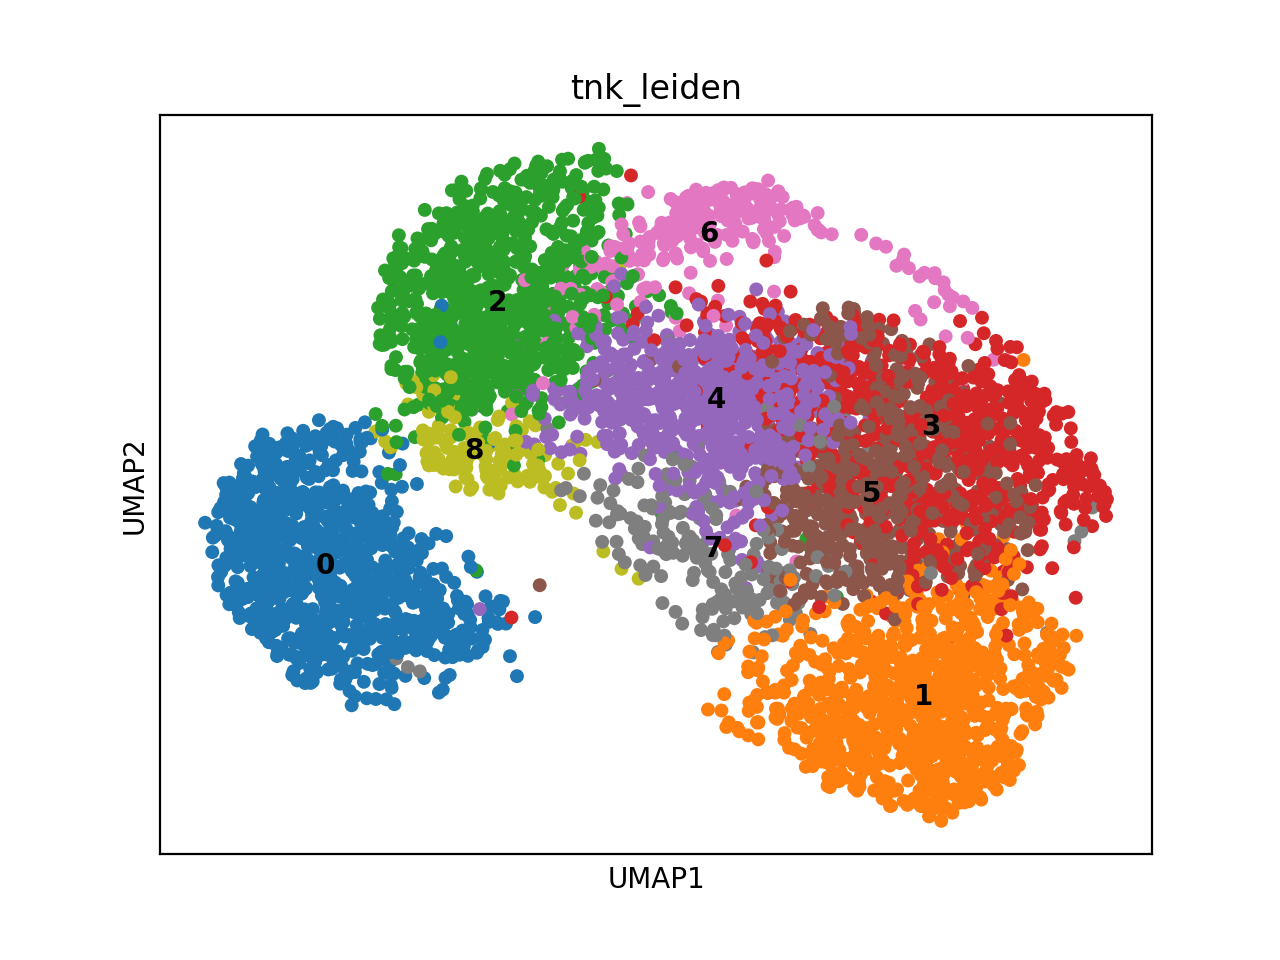

In [301]:
sc.pl.umap(tnk, color='tnk_leiden', legend_loc='on data', size=100)

In [20]:
sc.tl.rank_genes_groups(tnk, groupby='tnk_leiden', method='t-test_overestim_var', key_added='tnk_rgg')

In [30]:
tnk_calls = {
        0: 'NK Cells',
        1: 'Mki67+ CD8+',
        2: 'Progenitor CD8+',
        3: 'Terminal Effector CD8+',
        4: 'Early Effector CD8+',
        5: 'Terminal Effector CD8+',
        6: 'Foxp3+ CD4+',
        7: 'Gzm-hi CD8+',
        8: 'Malat1-hi CD8+'
}
conditions = tnk.obs['tnk_leiden'].astype(int).map(tnk_calls)
tnk.obs["tnk_clusters"] = np.where(tnk.obs['tnk_leiden'].astype(int).isin(tnk_calls.keys()), conditions.astype('category'), tnk.obs['tnk_leiden'])

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


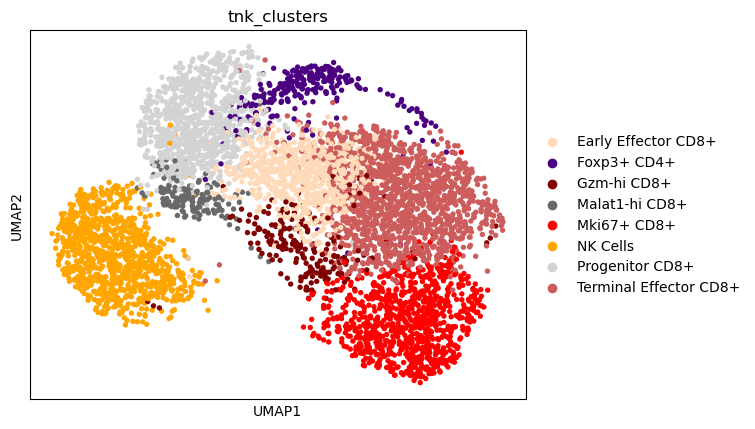

In [25]:
sc.pl.umap(tnk, color='tnk_clusters', palette=tnk_palette, size=60, save='09272023_tnk_clusters.pdf')

In [34]:
tnk_ds = tnk.copy()

In [35]:
keys= tnk_ds.obs["treatment"].unique()
size_order = tnk_ds.obs["treatment"].value_counts().sort_values().index
comb_df = pd.DataFrame(list(combinations(keys, 2)))
comb_df[0] = pd.Categorical(comb_df[0], categories=size_order, ordered=True)
comb_df[1] = pd.Categorical(comb_df[1], categories=size_order, ordered=True)
comb_df = comb_df.sort_values(0).sort_values(1)
# check that sample sizes are within 10% of each other
for c in comb_df.values:
    s1 = (tnk_ds.obs["treatment"] == c[0]).sum()
    s2 = (tnk_ds.obs["treatment"] == c[1]).sum()
    if abs(s1 - s2) / max(s1, s2) > 0.1:
        larger = c[np.argmax([s1, s2])]
        smaller = c[np.argmin([s1, s2])]
        tnk_ds = stratified_downsample(tnk_ds, "treatment", smaller, larger, 'tnk_clusters')

Downsampling larger set (aPD1 [4193]) to smaller set (Isotype [1271])


0        1.316477
1        1.578062
2       -1.460630
3        8.357339
4        9.299683
          ...    
2537     5.908606
2538    10.220199
2539     5.296320
2540     0.402149
2541     9.677169
Name: x, Length: 2542, dtype: float32
0       4.031976
1       9.978638
2       4.894280
3       2.293403
4       6.519477
          ...   
2537    6.981184
2538    6.239151
2539    9.353630
2540    4.319024
2541    3.882629
Name: y, Length: 2542, dtype: float32


/Users/sanderso/Library/CloudStorage/GoogleDrive-sanderso@broadinstitute.org/Shared drives/Manguso_Lab_Compbio/11_computational_biology/methods/scRNAseq/10x_pipeline/galaxy_20230607_2.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

/Users/sanderso/Library/CloudStorage/GoogleDrive-sanderso@broadinstitute.org/Shared drives/Manguso_Lab_Compbio/11_computational_biology/methods/scRNAseq/10x_pipeline/galaxy_20230607_2.py:66: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

/Users/sanderso/Library/CloudStorage/GoogleDrive-sanderso@broadinstitute.org/Shared drives/Manguso_Lab_Compbio/11_computational_biology/methods/scRNAseq/10x_pipeline/galaxy_20230607_2.py:66: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in se

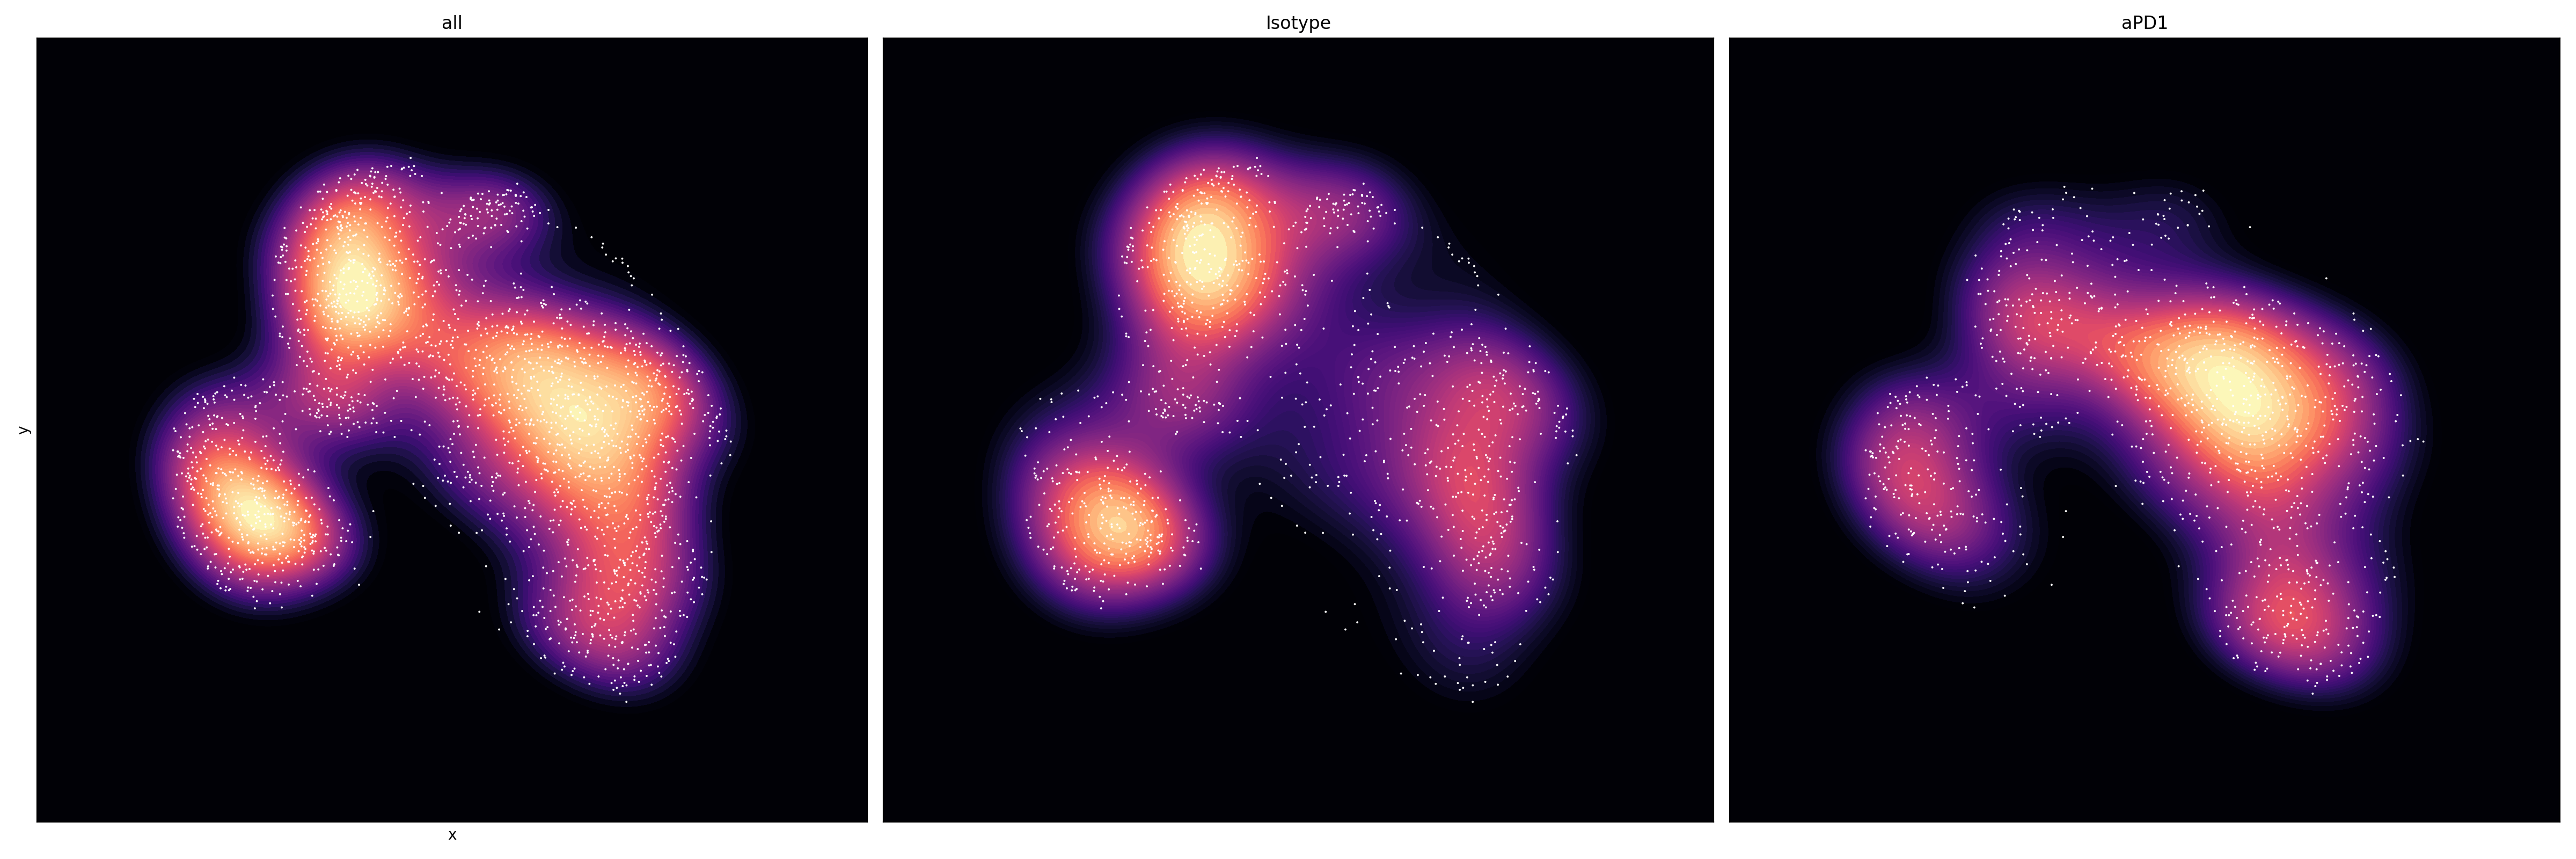

In [58]:
galaxy_20230607_2.galaxy_plot(tnk_ds, OUTDIR, 'treatment')

In [51]:
tnk_ds.write_h5ad(os.path.join(OUTDIR, 'tnk_ds.h5ad'))

In [38]:
tnk_clust = get_cluster_proportions(tnk, cluster_key='tnk_clusters', sample_key='replicate')

In [39]:
tnk_clust

tnk_clusters  Early Effector CD8+  Foxp3+ CD4+  Gzm-hi CD8+  Malat1-hi CD8+  \
replicate                                                                     
iso_1                    4.909091     7.454545     6.000000        8.727273   
iso_2                    2.636535    10.546139     0.564972        1.506591   
iso_3                    8.947368     5.789474     1.578947        2.631579   
pd1_1                   17.860152     2.948610     4.717776        2.527380   
pd1_2                   10.208817     3.596288     3.944316        0.928074   
pd1_3                   10.443038     4.008439     3.270042        3.270042   
pd1_4                   21.237458     3.678930     3.846154        2.173913   

tnk_clusters  Mki67+ CD8+   NK Cells  Progenitor CD8+  Terminal Effector CD8+  
replicate                                                                      
iso_1           14.545455  11.454545        26.000000               20.909091  
iso_2            7.344633  36.158192        26.553672               14.689266  
iso_3           14.736842  16.315789        37.368421               12.631579  
pd1_1           22.072452  19.460826        10.867734               19.545072  
pd1_2           14.849188  14.965197        12.877030               38.631090  
pd1_3           12.130802  17.194093        12.658228               37.025316  
pd1_4           19.397993  14.966555        12.458194               22.240803

In [40]:
tnk_clust.to_csv(os.path.join(OUTDIR, 'tnk_clust.csv'))

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


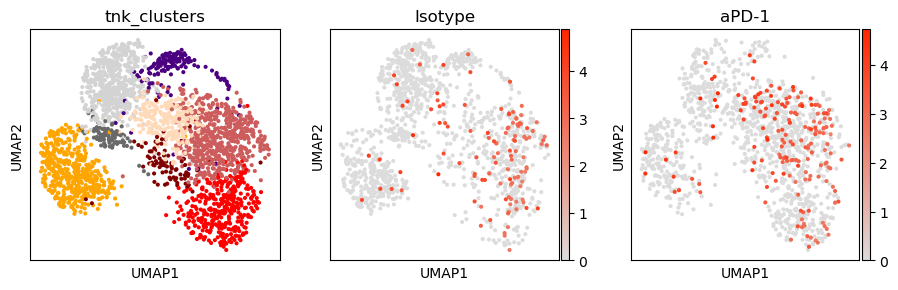

In [24]:
fig, (ax1, ax2, ax3) = mpl.subplots(1, 3, figsize=(11,3), gridspec_kw={'wspace':0.2}) 
sc.pl.umap(tnk_ds, color='tnk_clusters', palette=tnk_palette, size=35, ax=ax1, legend_loc=None, show=False)
sc.pl.umap(tnk_ds[tnk_ds.obs.treatment=='Isotype'], color='Cd38', cmap=greyred, size=35, ax=ax2, show=False, title='Isotype')
sc.pl.umap(tnk_ds[tnk_ds.obs.treatment=='aPD1'], color='Cd38', cmap=greyred, size=35, ax=ax3, show=False, title='aPD-1')

mpl.savefig('tnk_09272023_umaps_downsampled_clusters_cd38exp.pdf')

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


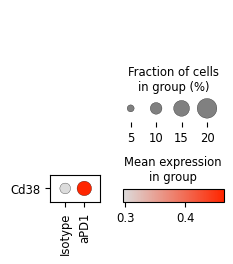

In [35]:
sc.pl.dotplot(tnk, groupby='treatment', cmap=greyred, var_names='Cd38', swap_axes=True)

In [37]:
sc.tl.score_genes(tnk, gene_list=['Cd38'], score_name='CD38_score_tnk')

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


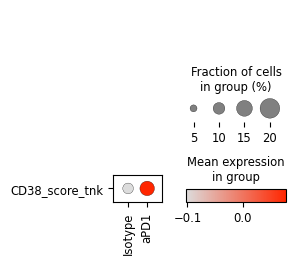

In [38]:
sc.pl.dotplot(tnk, groupby='treatment', cmap=greyred, var_names='CD38_score_tnk', swap_axes=True)

In [14]:
tnk.obs.loc[tnk.obs.CD38_score <= 0, 'CD38_status_tnk'] = 'CD38_neg'

In [15]:
tnk.obs.loc[tnk.obs.CD38_score > 0, 'CD38_status_tnk'] = 'CD38_pos'

In [88]:
tnk_ds.obs.loc[tnk_ds.obs.CD38_score <= 0, 'CD38_status_tnk'] = 'CD38_neg'

In [89]:
tnk_ds.obs.loc[tnk_ds.obs.CD38_score > 0, 'CD38_status_tnk'] = 'CD38_pos'

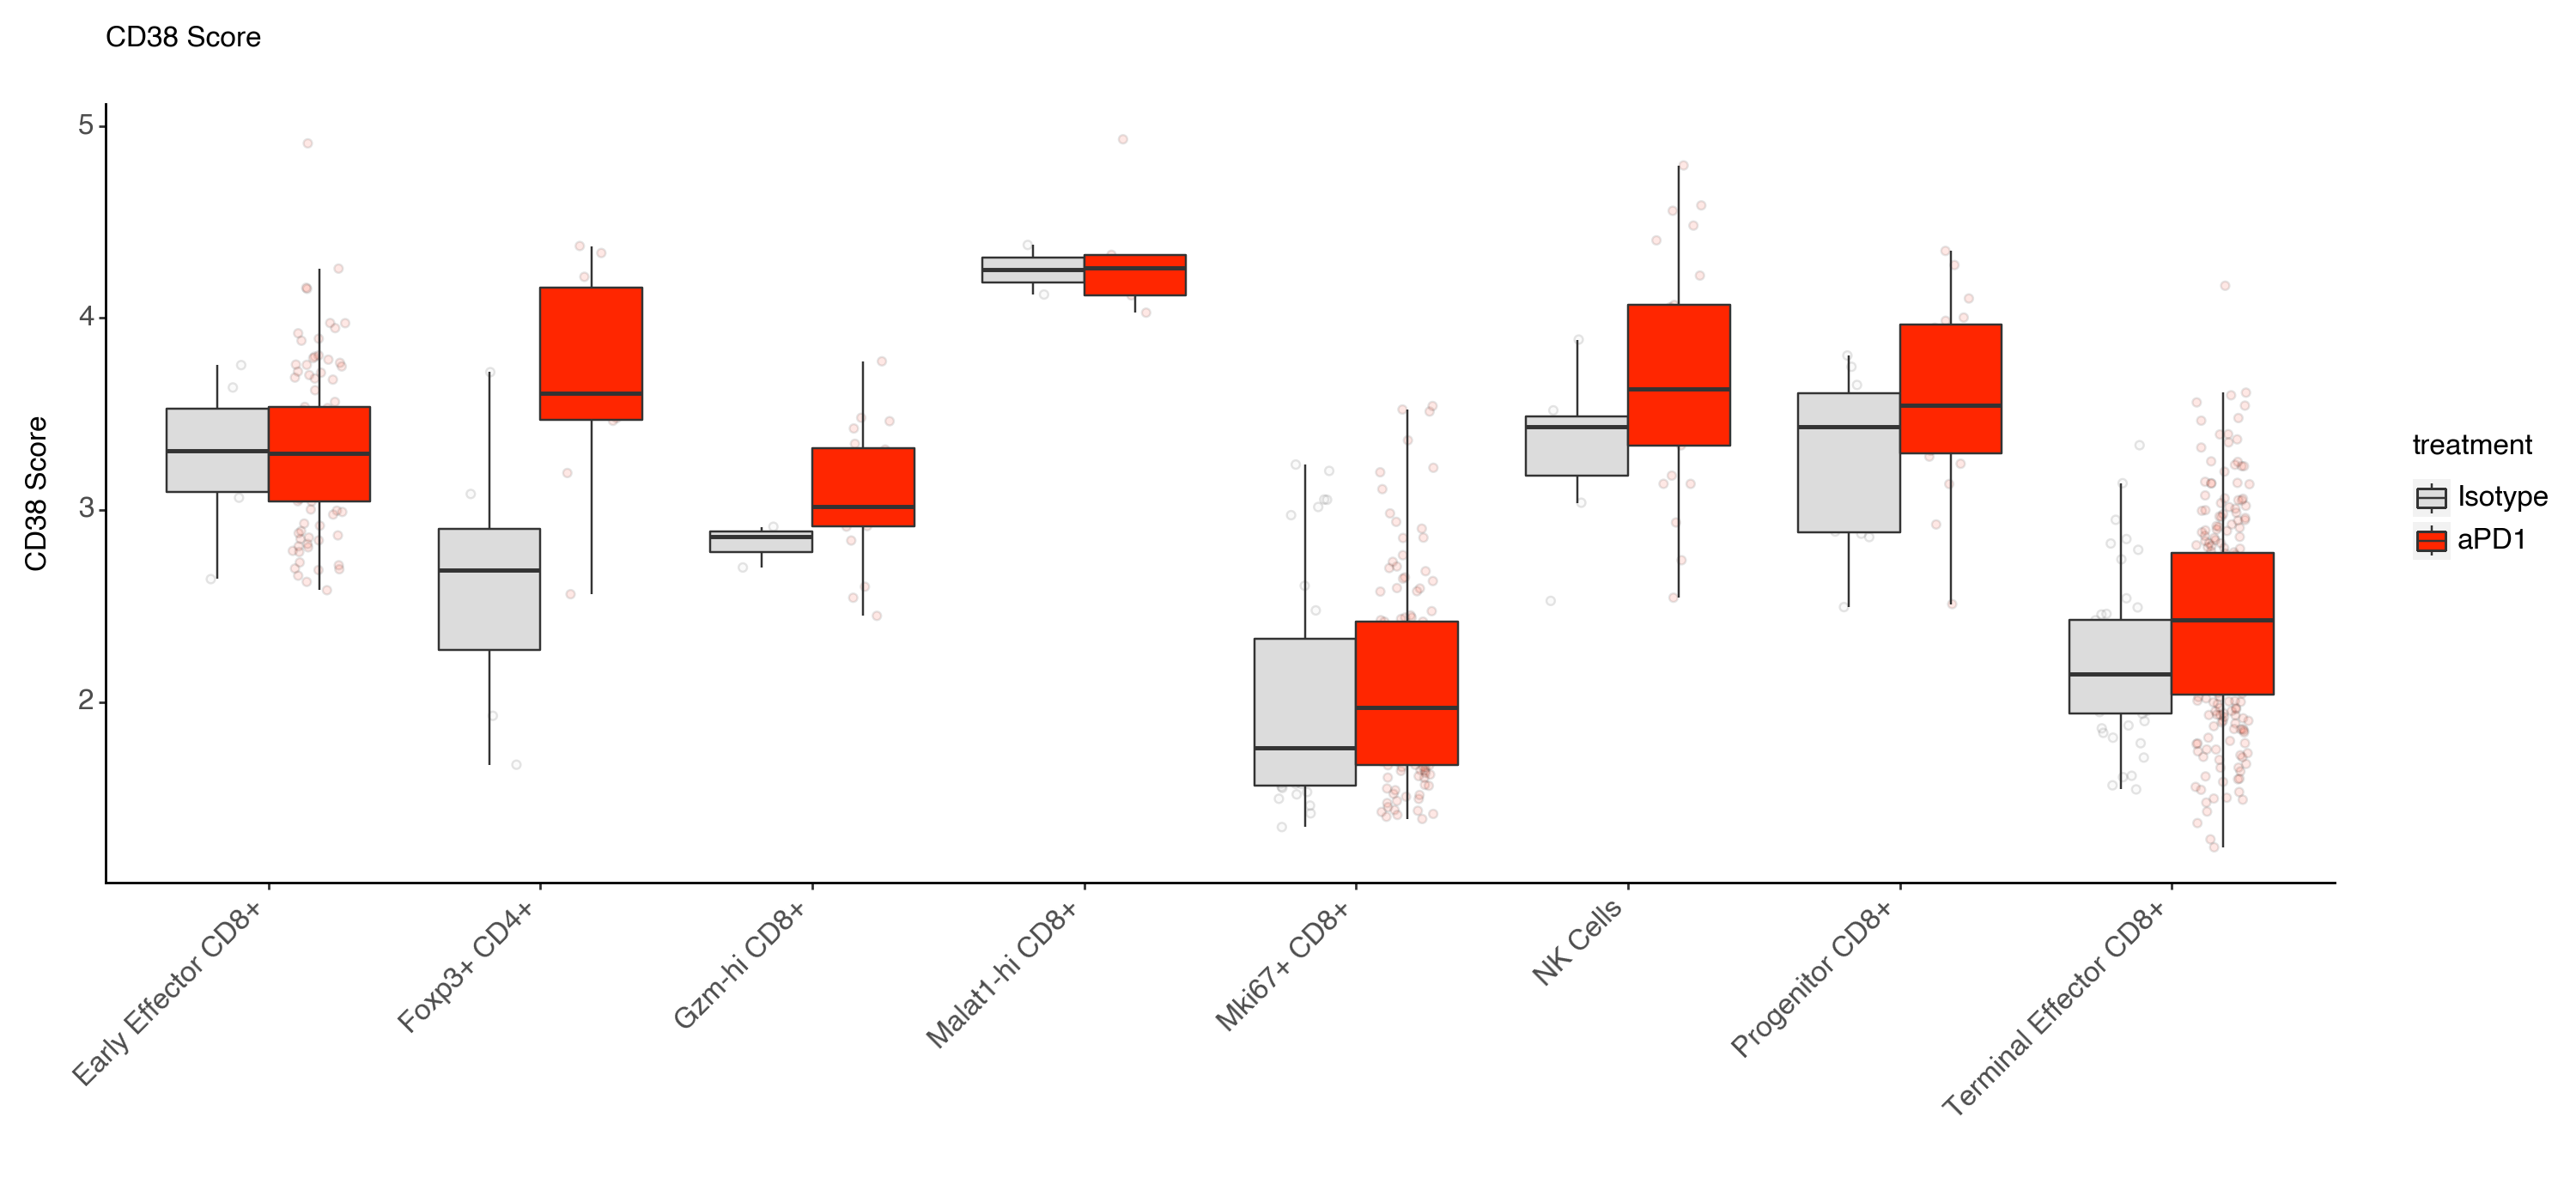

<Figure Size: (1500 x 700)>

In [17]:
plot = (ggplot(aes(x='tnk_clusters', y='CD38_score', fill='treatment'), tnk[tnk.obs['CD38_status_tnk']=='CD38_pos'].obs)
     + geom_point(position=position_jitterdodge(), alpha=0.1, color='black', show_legend=True)
     + geom_boxplot(outlier_alpha=0, show_legend=True, position = position_dodge(preserve = "single"))
     #+ theme(
     #legend_text = element_blank(),
        #legend_key = element_blank(),
        #legend_box = element_blank(),
        #legend_title = element_blank(),
        #legend_position = element_blank())
     + scale_fill_manual(name='treatment', values=["gainsboro", "#FF2600"])
     + theme(axis_text_x=element_text(rotation=90, hjust=1))
     + ylab('CD38 Score')
     + xlab('')
     + ggtitle('CD38 Score')
     #+ theme(aspect_ratio=10/20)
     + theme(
        axis_line=element_line(size=1, colour="black"),
        panel_grid_minor=element_blank(),
        panel_background=element_blank(),
        panel_border=element_rect(colour='black'),
        text=element_text(size = 12),
        figure_size=(15, 7),
        axis_text_x=element_text(rotation=45, hjust=1)
        
    )
     )
plot

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 15 x 7 in image.
/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/sanderso/Documents/Broad/10X/CD38_reanalysis/tnk_posonly_downsampled.pdf


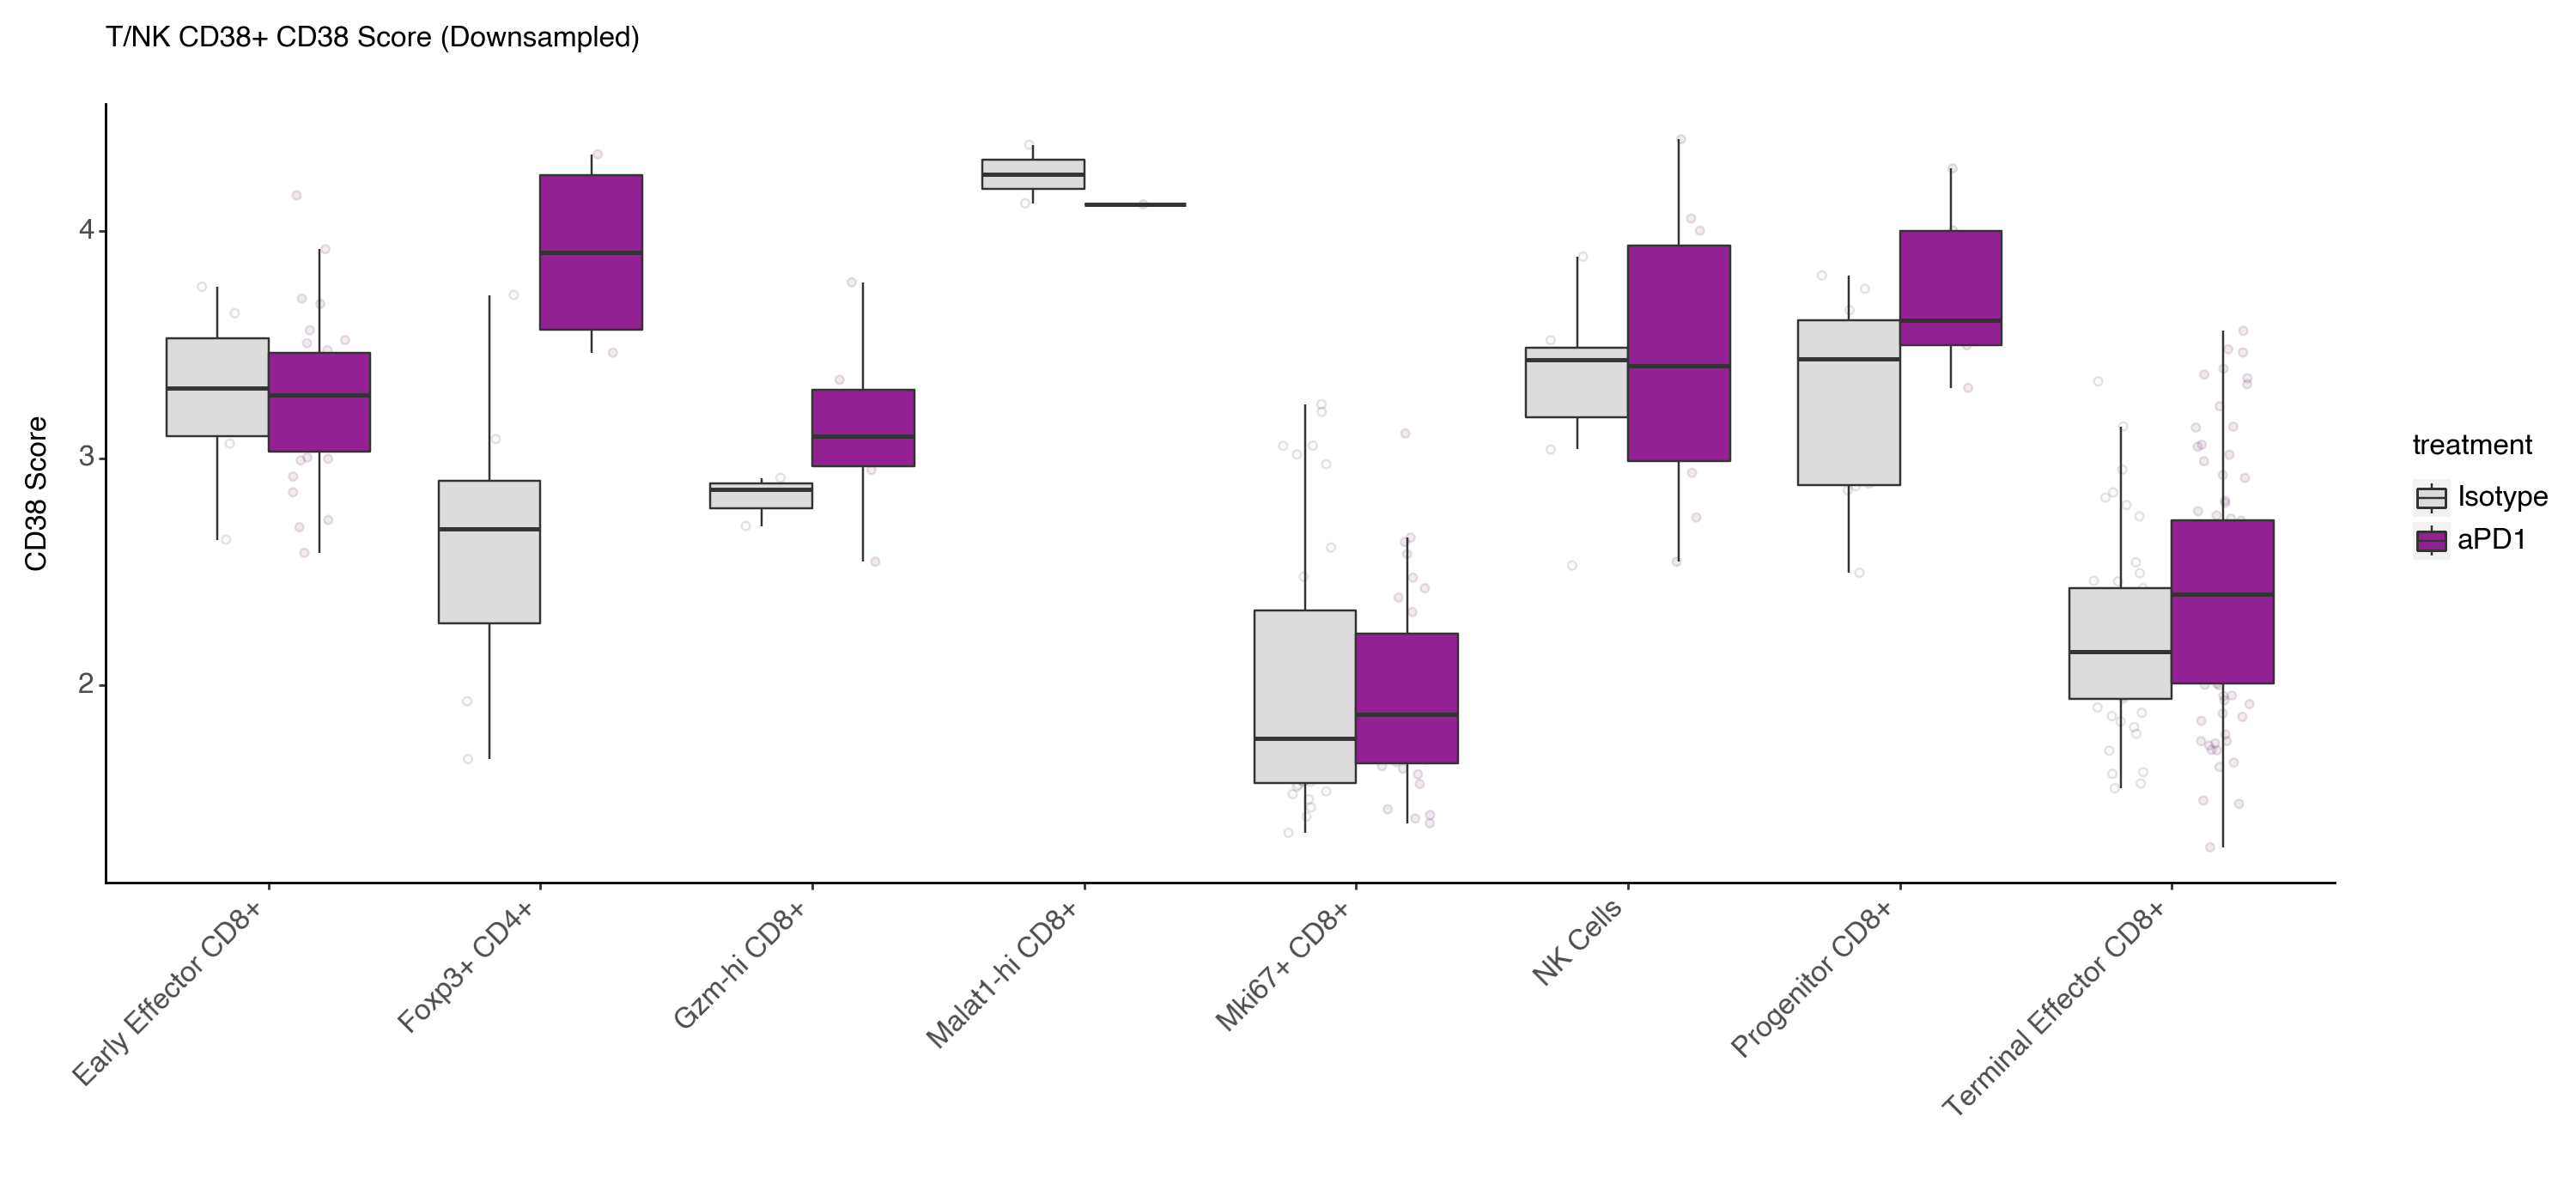

<Figure Size: (1500 x 700)>

In [91]:
plot = (ggplot(aes(x='tnk_clusters', y='CD38_score', fill='treatment'), tnk_ds[tnk_ds.obs['CD38_status_tnk']=='CD38_pos'].obs)
     + geom_point(position=position_jitterdodge(), alpha=0.1, color='black', show_legend=True)
     + geom_boxplot(outlier_alpha=0, show_legend=True, position = position_dodge(preserve = "single"))
     #+ theme(
     #legend_text = element_blank(),
        #legend_key = element_blank(),
        #legend_box = element_blank(),
        #legend_title = element_blank(),
        #legend_position = element_blank())
     + scale_fill_manual(name='treatment', values=["gainsboro", "#942193"])
     + theme(axis_text_x=element_text(rotation=90, hjust=1))
     + ylab('CD38 Score')
     + xlab('')
     + ggtitle('T/NK CD38+ CD38 Score (Downsampled)')
     #+ theme(aspect_ratio=10/20)
     + theme(
        axis_line=element_line(size=1, colour="black"),
        panel_grid_minor=element_blank(),
        panel_background=element_blank(),
        panel_border=element_rect(colour='black'),
        text=element_text(size = 12),
        figure_size=(15, 7),
        axis_text_x=element_text(rotation=45, hjust=1)
        
    )
     )
plot.save(os.path.join(OUTDIR, 'tnk_posonly_downsampled.pdf'))
plot

In [21]:
tnk.write_h5ad(os.path.join(OUTDIR, 'tnk.h5ad'))

# Dot plots, tracks plots, updated color palettes

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


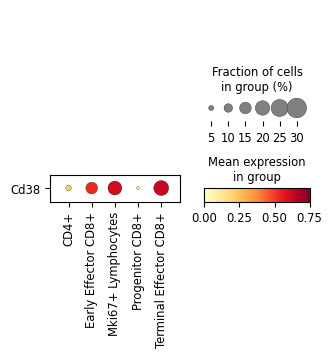

In [40]:
sc.pl.dotplot(bulkt[bulkt.obs.treatment == 'Isotype'], groupby=['pd1_clusters_1.4'], cmap='YlOrRd', var_names='Cd38', swap_axes=True, vmin=0, vmax=0.75)

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


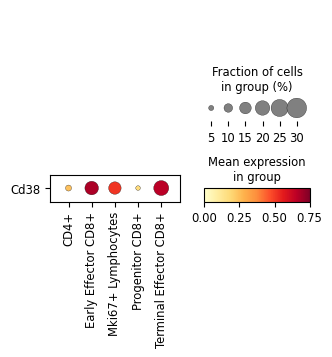

In [41]:
sc.pl.dotplot(bulkt[bulkt.obs.treatment == 'aPD1'], groupby=['pd1_clusters_1.4'], cmap='YlOrRd', var_names='Cd38', swap_axes=True, vmin=0, vmax=0.75)

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


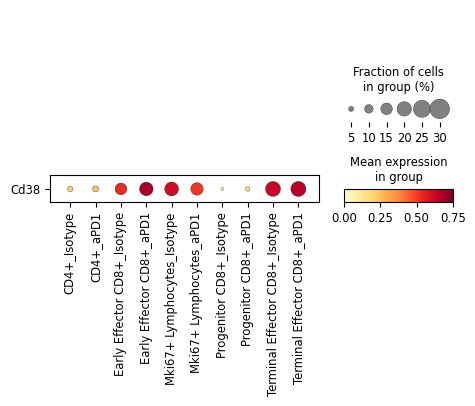

In [31]:
sc.pl.dotplot(bulkt, groupby=['pd1_clusters_1.4','treatment'], cmap='YlOrRd', var_names='Cd38', swap_axes=True, vmin=0, vmax=0.75, save='bulkt_dotplot.pdf')

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


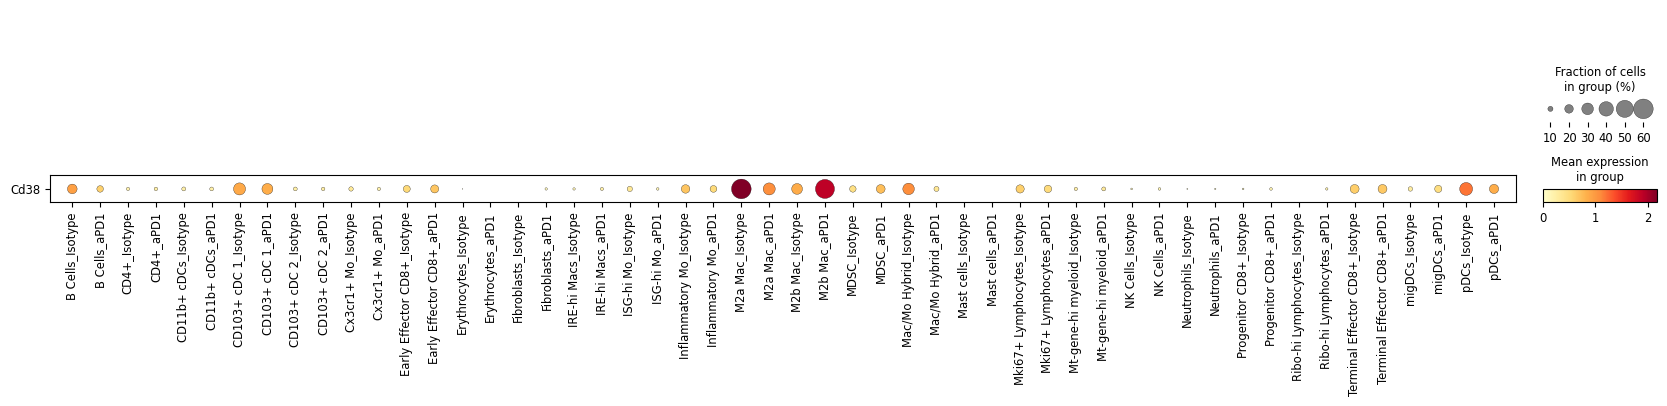

In [51]:
sc.pl.dotplot(pd1, groupby=['pd1_clusters_1.4','treatment'], cmap='YlOrRd', var_names='Cd38', swap_axes=True, save='bulk_dotplot.pdf')

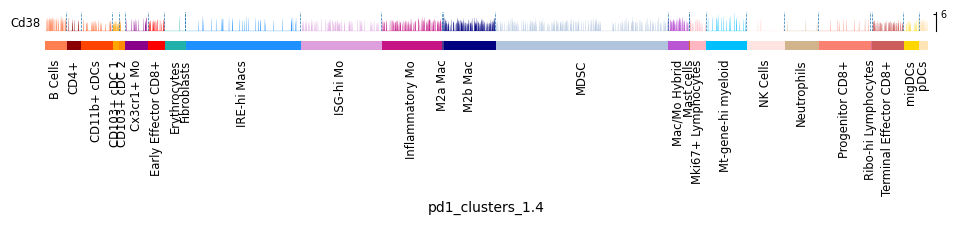

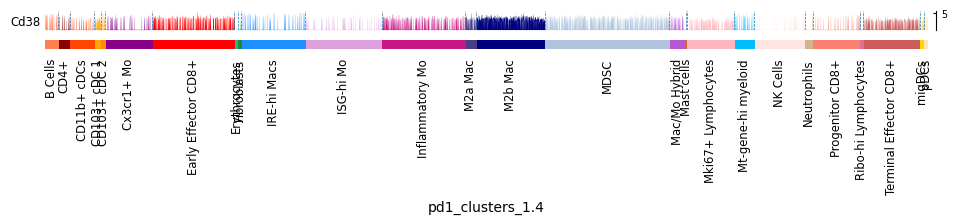

In [57]:
sc.pl.tracksplot(pd1[pd1.obs.treatment == 'Isotype'], var_names='Cd38', groupby='pd1_clusters_1.4', save='bulk_isotype_cd38_tracksplot.pdf')
sc.pl.tracksplot(pd1[pd1.obs.treatment == 'aPD1'], var_names='Cd38', groupby='pd1_clusters_1.4', save='bulk_apd1_cd38_tracksplot.pdf')

In [95]:
bulkt_ds = bulkt.copy()

In [96]:
keys= bulkt_ds.obs["treatment"].unique()
size_order = bulkt_ds.obs["treatment"].value_counts().sort_values().index
comb_df = pd.DataFrame(list(combinations(keys, 2)))
comb_df[0] = pd.Categorical(comb_df[0], categories=size_order, ordered=True)
comb_df[1] = pd.Categorical(comb_df[1], categories=size_order, ordered=True)
comb_df = comb_df.sort_values(0).sort_values(1)
# check that sample sizes are within 10% of each other
for c in comb_df.values:
    s1 = (bulkt_ds.obs["treatment"] == c[0]).sum()
    s2 = (bulkt_ds.obs["treatment"] == c[1]).sum()
    if abs(s1 - s2) / max(s1, s2) > 0.1:
        larger = c[np.argmax([s1, s2])]
        smaller = c[np.argmin([s1, s2])]
        bulkt_ds = stratified_downsample(bulkt_ds, "treatment", smaller, larger, 'pd1_clusters_1.4')

Downsampling larger set (aPD1 [3477]) to smaller set (Isotype [982])


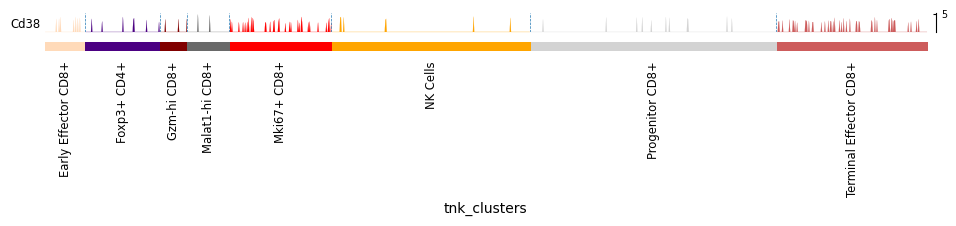

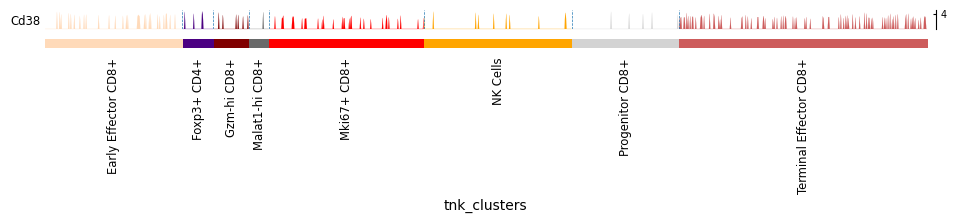

In [28]:
sc.pl.tracksplot(tnk_ds[tnk_ds.obs.treatment == 'Isotype'], var_names='Cd38', groupby='tnk_clusters', save='tnk_isotype_cd38_tracksplot_DOWNSAMPLED.pdf')
sc.pl.tracksplot(tnk_ds[tnk_ds.obs.treatment == 'aPD1'], var_names='Cd38', groupby='tnk_clusters', save='tnk_apd1_cd38_tracksplot_DOWNSAMPLED.pdf')

In [24]:
greypurp = matplotlib.colors.LinearSegmentedColormap.from_list("", ["gainsboro","#932192"])

/Applications/anaconda3/envs/new_10x_pipeline/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


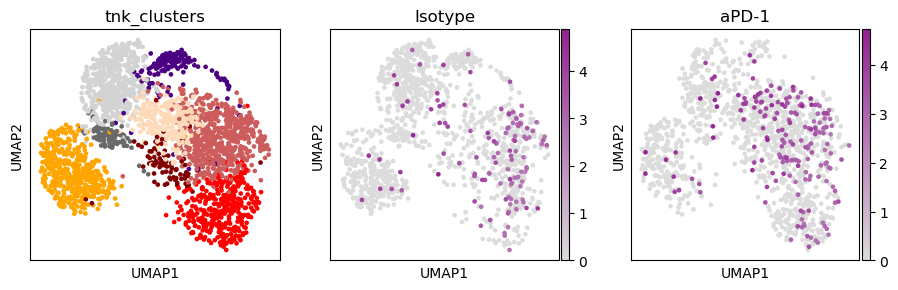

In [28]:
fig, (ax1, ax2, ax3) = mpl.subplots(1, 3, figsize=(11,3), gridspec_kw={'wspace':0.2}) 
sc.pl.umap(tnk_ds, color='tnk_clusters', palette=tnk_palette, size=45, ax=ax1, legend_loc=None, show=False)
sc.pl.umap(tnk_ds[tnk_ds.obs.treatment=='Isotype'], color='Cd38', cmap=greypurp, size=45, ax=ax2, show=False, title='Isotype')
sc.pl.umap(tnk_ds[tnk_ds.obs.treatment=='aPD1'], color='Cd38', cmap=greypurp, size=45, ax=ax3, show=False, title='aPD-1')

mpl.savefig('tnk_11092023_umaps_downsampled_clusters_cd38exp_purple.pdf')